In [19]:
# CELL 1 — Install any packages not preinstalled in Colab
# Optuna, LightGBM, SHAP, and imbalanced-learn may not be installed by default.
# Run this cell once (it may take ~1-2 minutes).

!pip install --quiet lightgbm optuna shap imbalanced-learn

print("✅ Packages installed (or already present).")


✅ Packages installed (or already present).


In [20]:
# CELL 2 — Import libraries
# Import standard libs for data, ML, plotting, imbalanced handling, and tuning.

import numpy as np
import pandas as pd
from datetime import datetime

# ML & preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# LightGBM
from lightgbm import LGBMClassifier

# Hyperparameter tuning
import optuna

# Explainability & plotting
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries imported.")


✅ Libraries imported.


## 📂 Step 1 – Dataset Overview and Loading

The dataset contains physicochemical measurements of milk samples collected from healthy and mastitic cows.  
Each row represents one observation with the following key columns:

| Feature | Description |
|----------|--------------|
| **SCC** | Somatic Cell Count (cells/mL) – main infection indicator |
| **pH** | Milk pH – rises slightly during infection |
| **EC_mS_per_cm** | Electrical Conductivity (mS/cm) – increases due to ion leakage |
| **MilkYield_L** | Daily milk yield per cow |
| **FatPct / ProteinPct** | Nutritional composition features |
| **Label** | 0 = Healthy, 1 = Subclinical Mastitis |

The next cell loads and previews the dataset.


In [46]:
# CELL 3 — Load dataset
# Upload your CSV to Colab (Files → Upload) and set file_path accordingly.
# The code supports both the synthetic file (mastitis_synthetic_ph_scc_ec.csv)
# and the clinical_mastitis_cows_version1.csv you uploaded earlier.

file_path = "mastitis_ph_scc_ec_realistic.csv"  # change if needed
df = pd.read_csv(file_path)

# Quick check: show top rows and columns list
print("Dataset shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))


Dataset shape: (5000, 9)


,CowID,Date,SCC,pH,EC_mS_per_cm,MilkYield_L,FatPct,ProteinPct,Label
0,C001,2024-08-23,1.000000e+00,6.147074,4.266774,20.46,3.89,3.10,0
1,C002,2024-07-03,1.288101e+06,6.641657,4.181833,16.15,3.07,3.33,1
2,C003,2024-05-28,1.807777e+05,6.484775,5.076630,27.31,3.91,3.30,0
3,C004,2024-07-12,2.401931e+05,6.629617,3.165354,19.77,4.17,3.25,0
4,C005,2024-09-05,3.614177e+05,7.141808,4.577090,25.94,3.66,2.98,0



Columns: ['CowID', 'Date', 'SCC', 'pH', 'EC_mS_per_cm', 'MilkYield_L', 'FatPct', 'ProteinPct', 'Label']


## 🔍 Step 2 – Exploratory Data Analysis (EDA)

Before model development, we explore the dataset to understand its structure, identify missing values, and inspect feature distributions.  
This step ensures the data follows expected biological patterns and helps detect any anomalies that could affect model accuracy.


In [80]:
# 🧩 CELL 3.1 — Basic Dataset Information

# Show general structure
print("🧾 Dataset Information:\n")
df.info()

# Summary statistics for numeric features
print("\n📊 Descriptive Statistics:\n")
display(df.describe())

# Check for missing or null values
print("\n🚫 Missing Values per Column:\n")
print(df.isnull().sum())


🧾 Dataset Information:

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1800 to 399
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CowID            5000 non-null   object        
 1   Date             5000 non-null   datetime64[ns]
 2   SCC              5000 non-null   float64       
 3   pH               5000 non-null   float64       
 4   EC_mS_per_cm     5000 non-null   float64       
 5   MilkYield_L      5000 non-null   float64       
 6   FatPct           5000 non-null   float64       
 7   ProteinPct       5000 non-null   float64       
 8   Label            5000 non-null   int64         
 9   log_SCC          5000 non-null   float64       
 10  SCC_over_EC      5000 non-null   float64       
 11  SCC_roll_mean_3  5000 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 507.8+ KB

📊 Descriptive Statistics:



,Date,SCC,pH,EC_mS_per_cm,MilkYield_L,FatPct,ProteinPct,Label,log_SCC,SCC_over_EC,SCC_roll_mean_3
count,5000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,2024-07-01 05:14:29.760000256,3.574812e+05,6.646909,4.305209,21.343416,3.684172,3.185974,0.146000,11.969805,78280.446560,3.593696e+05
min,2024-01-01 00:00:00,1.000000e+00,6.051426,2.374482,5.000000,2.390000,2.400000,0.000000,0.693147,0.187032,1.000000e+00
25%,2024-04-02 00:00:00,1.399999e+05,6.516879,3.804470,18.547500,3.480000,3.040000,0.000000,11.849404,34108.414714,1.925366e+05
50%,2024-06-30 00:00:00,2.380008e+05,6.631289,4.198115,21.555000,3.690000,3.190000,0.000000,12.380034,57326.194556,2.832073e+05
75%,2024-09-29 00:00:00,3.849248e+05,6.755678,4.626939,24.282500,3.900000,3.330000,0.000000,12.860806,94090.772334,4.577790e+05
max,2024-12-30 00:00:00,3.965002e+06,7.479032,7.500000,35.340000,4.710000,3.890000,1.000000,15.193017,904944.293332,2.406600e+06
std,NaN,4.094915e+05,0.193756,0.772520,4.369495,0.318250,0.213482,0.353142,2.392182,76943.562076,2.464206e+05



🚫 Missing Values per Column:

CowID              0
Date               0
SCC                0
pH                 0
EC_mS_per_cm       0
MilkYield_L        0
FatPct             0
ProteinPct         0
Label              0
log_SCC            0
SCC_over_EC        0
SCC_roll_mean_3    0
dtype: int64


### 🔹 Correlation Heatmap

The correlation heatmap below visualizes linear relationships between all numerical features.  
It helps identify the most influential predictors of mastitis and check for multicollinearity among engineered variables.


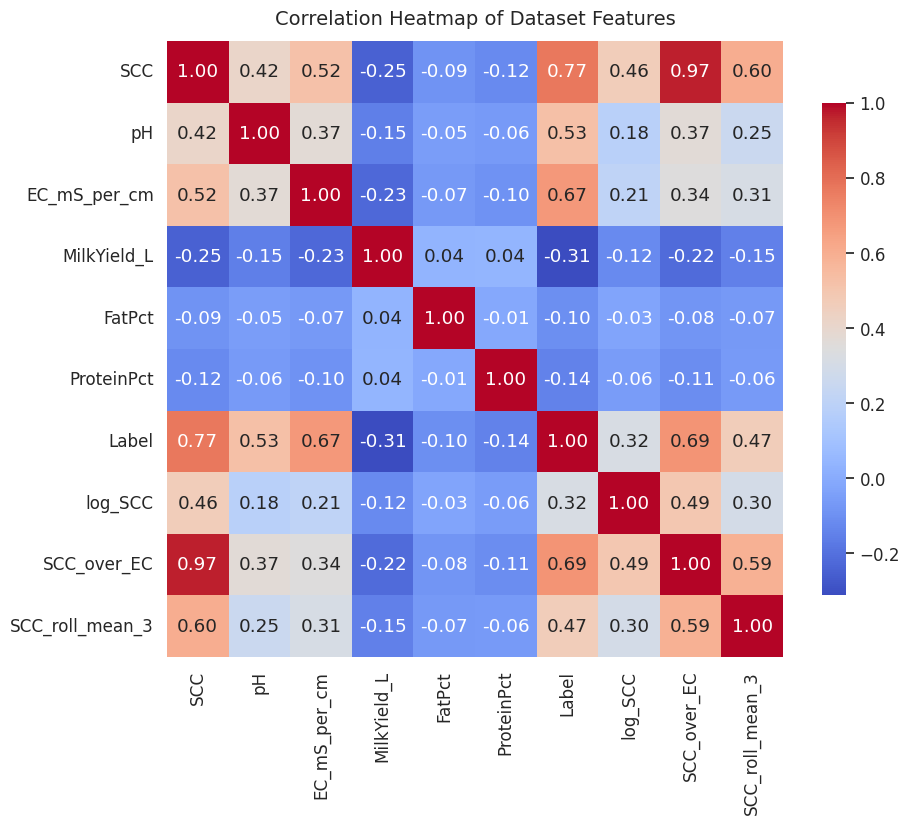

<Figure size 640x480 with 0 Axes>

In [77]:
# 🧩 CELL 4 — Correlation Heatmap (Early Stage)
# Purpose:
#   • Visualize relationships among features before model training
#   • Detect multicollinearity or redundant variables
#   • Identify strongest predictors related to 'Label'

import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numeric columns
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Heatmap of Dataset Features", fontsize=14, pad=12)
plt.show()
plt.savefig("figure3_heatmap.png", dpi=300, bbox_inches='tight')



### 📊 Step 2.2 – Feature Distribution by Health Condition

Boxplots are used to visualize how **SCC**, **pH**, and **Electrical Conductivity (EC)** differ between healthy and mastitis-affected samples.  
This allows us to see the median, spread, and potential outliers for each feature, helping confirm which indicators show the clearest separation.

In subclinical mastitis cases, we expect:
- **SCC** to be significantly higher,  
- **EC** to increase due to ionic leakage, and  
- **pH** to show a slight upward shift.


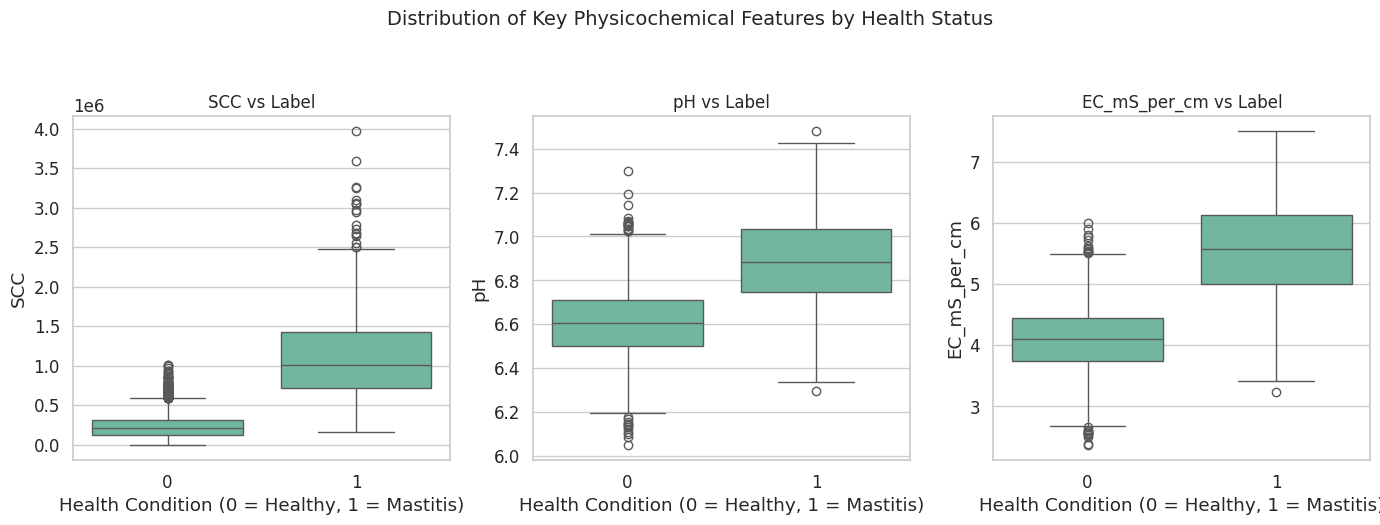

In [76]:
# 🧩 CELL 5 — Feature Distribution Visualization (Boxplots by Class)
# Purpose:
#   • Compare distributions of key features between Healthy (0) and Mastitis (1)
#   • Confirm which variables show strongest separation early in the pipeline

import seaborn as sns
import matplotlib.pyplot as plt

# Set consistent style for publication-quality figures
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

features_to_plot = ["SCC", "pH", "EC_mS_per_cm"]

plt.figure(figsize=(14, 5))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="Label", y=feature, data=df)
    plt.title(f"{feature} vs Label", fontsize=12)
    plt.xlabel("Health Condition (0 = Healthy, 1 = Mastitis)")
    plt.ylabel(feature)
plt.suptitle("Distribution of Key Physicochemical Features by Health Status", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


## ⚙️ Step 3 – Feature Engineering

To enhance model performance, several derived features are introduced:

- **log_SCC** → reduces skewness and normalizes large SCC values.  
- **SCC_over_EC** → ratio feature combining SCC and EC influence.  
- **SCC_roll_mean_3** → 3-sample rolling mean showing SCC stability over time.

These features help the model capture subtle physiological patterns related to early-stage mastitis.


In [50]:
# CELL 6 — Feature engineering
# 1) log_SCC (log transform reduces skew)
# 2) SCC_over_EC ratio
# 3) rolling_mean_SCC per CowID (if CowID and Date present)

# 6.1 log transform of SCC (add small constant to avoid log(0))
df["log_SCC"] = np.log1p(df[scc])

# 6.2 SCC/EC ratio
df["SCC_over_EC"] = df[scc] / (df[ec].replace(0, np.nan))

# 6.3 Rolling mean of SCC per cow (if CowID and Date exist)
if "CowID" in df.columns and "Date" in df.columns:
    # ensure Date is datetime and sort
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.sort_values(["CowID", "Date"])
    # compute rolling mean of SCC with window=3 per cow (min_periods=1)
    df["SCC_roll_mean_3"] = df.groupby("CowID")[scc].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
else:
    # if no CowID/Date, create simple rolling using overall ordering
    df["SCC_roll_mean_3"] = df[scc].rolling(window=3, min_periods=1).mean()

# Fill any infinite or NaN from ratio
df["SCC_over_EC"] = df["SCC_over_EC"].replace([np.inf, -np.inf], np.nan).fillna(df["SCC_over_EC"].median())
df["SCC_roll_mean_3"] = df["SCC_roll_mean_3"].fillna(df[scc].median())

print("Feature engineering complete. Columns added: log_SCC, SCC_over_EC, SCC_roll_mean_3")
display(df[[scc, "log_SCC", ec, "SCC_over_EC", "SCC_roll_mean_3"]].head())


Feature engineering complete. Columns added: log_SCC, SCC_over_EC, SCC_roll_mean_3


,SCC,log_SCC,EC_mS_per_cm,SCC_over_EC,SCC_roll_mean_3
1800,643898.800142,13.375298,6.148919,104717.396057,643898.800142
1200,182461.069486,12.114298,4.913457,37134.971702,413179.934814
4600,242829.766225,12.400120,3.812729,63689.230451,356396.545284
2000,276117.361758,12.528585,3.802048,72623.315304,233802.732490
3400,250231.562495,12.430146,3.636322,68814.476378,256392.896826


### 🧩 Step 3.2 – Feature Selection and Target Preparation

After generating the engineered features, the next step is to define the final input features (`X`) and the output label (`y`) for model training.

- The **core features** include `SCC`, `pH`, and `EC_mS_per_cm`.  
- The **engineered features** include `log_SCC`, `SCC_over_EC`, and `SCC_roll_mean_3`.  
- Optional features such as milk yield, fat, and protein percentage are included if available.

The target variable (`Label`) represents the cow’s health condition:
- `0` → Healthy  
- `1` → Subclinical Mastitis  

This step finalizes the dataset used for machine learning model training and evaluation.


In [81]:
# CELL 7 — Prepare X and y
# Choose final features (core + engineered + optional extras if present).
# Ensure the target is present; if not, create from threshold (optional) — but Phase1 expects label.

features = []
# include main features
features += [scc, ph, ec]
# add engineered
features += ["log_SCC", "SCC_over_EC", "SCC_roll_mean_3"]
# optional columns if exist
for opt in ["MilkYield_L", "MilkYield", "MilkYield_Liters", "MilkYield_Litres", "MilkYield_Ltr", "FatPct", "ProteinPct"]:
    if opt in df.columns:
        features.append(opt)

# Ensure features are unique and present
features = [f for f in features if f in df.columns]
print("Final features used:", features)

# target handling
if label is None:
    raise ValueError("No label column detected. Phase-1 requires a 'Label' or 'class1' target column.")
y = df[label].astype(int)
X = df[features].copy()

print("X shape:", X.shape, "y shape:", y.shape)


Final features used: ['SCC', 'pH', 'EC_mS_per_cm', 'log_SCC', 'SCC_over_EC', 'SCC_roll_mean_3', 'MilkYield_L', 'FatPct', 'ProteinPct']
X shape: (5000, 9) y shape: (5000,)


## 🧩 Step 4 – Data Splitting and Preprocessing

To evaluate model generalization, the dataset is divided into **training and testing subsets**.  
Only the training data is used for scaling (standardization) and oversampling (if required) to prevent data leakage.  
All numeric features are standardized using `StandardScaler` to ensure fair weighting across SCC, EC, and pH values.


In [52]:
# CELL 8 — Train/test split and SMOTE
# Stratify split to keep label distribution. Then apply SMOTE on the training set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Before SMOTE, training label distribution:")
print(y_train.value_counts(normalize=True))

# Apply SMOTE to training set only (helps with imbalanced classes)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE, training label distribution:")
print(pd.Series(y_train_res).value_counts(normalize=True))

# Standardize numeric features (fit on resampled training data)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing complete. Shapes -> X_train:", X_train_res_scaled.shape, "X_test:", X_test_scaled.shape)


Before SMOTE, training label distribution:
Label
0    0.853867
1    0.146133
Name: proportion, dtype: float64
After SMOTE, training label distribution:
Label
0    0.5
1    0.5
Name: proportion, dtype: float64
Preprocessing complete. Shapes -> X_train: (6404, 9) X_test: (1250, 9)


## 🧠 Step 5 – Baseline Model: Logistic Regression

Logistic Regression is used as a baseline model because of its simplicity and interpretability.  
It performs well when the features show near-linear separability, as is the case with **SCC**, **pH**, and **EC**.  

Key points:
- Uses **L2 regularization** to avoid overfitting.  
- Evaluated using **cross-validation** to estimate realistic accuracy.  
- Metrics such as **precision**, **recall**, and **F1-score** are reported for both classes (healthy / mastitis).

This baseline provides a benchmark for comparing advanced models such as LightGBM.


In [73]:
# CELL 9 — Train and evaluate Logistic Regression baseline
lr = LogisticRegression(max_iter=300, random_state=42, C=0.15, solver='liblinear')
lr.fit(X_train_res_scaled, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression performance on test set:")
print(classification_report(y_test, y_pred_lr, digits=4))


Logistic Regression performance on test set:
              precision    recall  f1-score   support

           0     0.9934    0.9841    0.9887      1068
           1     0.9115    0.9615    0.9358       182

    accuracy                         0.9808      1250
   macro avg     0.9524    0.9728    0.9623      1250
weighted avg     0.9815    0.9808    0.9810      1250



### 🎯 Step 6.1 – Hyperparameter Tuning using Optuna

In this step, the LightGBM model undergoes **Bayesian hyperparameter optimization** using Optuna.  
This automatically explores combinations of parameters such as:
- `learning_rate`, `num_leaves`, `max_depth`
- `min_child_samples`, `subsample`, `colsample_bytree`
- `reg_alpha`, `reg_lambda`

Each combination is evaluated using **F1-score** under 3-fold cross-validation.  
The goal is to maximize the model’s ability to detect mastitis cases accurately while avoiding overfitting.


In [28]:
# ✅ FIXED CELL 10 — Optuna tuning for LightGBM (compatible with newer versions)
# This version replaces 'early_stopping_rounds' with callbacks to avoid TypeError.

from lightgbm import early_stopping, log_evaluation

def objective(trial):
    # Define the search space for hyperparameters
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "seed": 42,
        "n_estimators": 1000,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0)
    }

    # Cross-validation loop
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1s = []
    for train_idx, val_idx in skf.split(X_train_res, y_train_res):
        X_tr, X_val = X_train_res.iloc[train_idx], X_train_res.iloc[val_idx]
        y_tr, y_val = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

        X_tr_s = scaler.transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # Define model and fit with new callback syntax
        model = LGBMClassifier(**param)
        model.fit(
            X_tr_s, y_tr,
            eval_set=[(X_val_s, y_val)],
            callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
        )

        y_pred = model.predict(X_val_s)
        f1s.append(f1_score(y_val, y_pred))
    return np.mean(f1s)

# Run Optuna optimization
study = optuna.create_study(direction="maximize", study_name="lgbm_mastitis_f1")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("✅ Best trial parameters:")
print(study.best_trial.params)


[I 2025-10-25 09:31:08,065] A new study created in memory with name: lgbm_mastitis_f1


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.0366296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.0423138
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.0426162
[I 2025-10-25 09:31:09,236] Trial 0 finished with value: 0.9851524225618999 and parameters: {'learning_rate': 0.04068706680246351, 'num_leaves': 168, 'max_depth': 11, 'min_child_samples': 78, 'subsample': 0.9535810607215176, 'colsample_bytree': 0.9159841465240506, 'reg_alpha': 4.195668214340777, 'reg_lambda': 1.871263720871272}. Best is trial 0 with value: 0.9851524225618999.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.029876
Training until validation scores don't improve for 50 rounds
Early sto

### 🔍 Step 6.2 – Best Trial Summary

Optuna finishes multiple trials and reports the parameter set that yields the highest validation F1-score.  
These optimized parameters are then used to retrain the LightGBM model on the full training dataset.  
This approach ensures strong generalization and avoids manual hyperparameter guessing.


In [29]:
# ✅ FIXED CELL 11 — Train LightGBM with best params (new API-compatible)
# This version replaces 'early_stopping_rounds' with callbacks and uses log_evaluation for clarity.

from lightgbm import early_stopping, log_evaluation

# Rebuild best_params safely
best_params = study.best_trial.params
best_params.update({
    "objective": "binary",
    "n_estimators": 1000,
    "verbosity": -1,
    "random_state": 42
})

# Create the LightGBM model
lgbm = LGBMClassifier(**best_params)

# Fit the model with the new callback syntax
lgbm.fit(
    X_train_res_scaled, y_train_res,
    eval_set=[(X_test_scaled, y_test)],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
)

# Predict on the test set
y_pred_lgbm = lgbm.predict(X_test_scaled)

# Evaluate model performance
print("✅ LightGBM performance on test set:")
print(classification_report(y_test, y_pred_lgbm, digits=4))

# Save feature names for SHAP explainability
feature_names = X.columns.tolist()


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.0448714
✅ LightGBM performance on test set:
              precision    recall  f1-score   support

           0     0.9925    0.9934    0.9930      1068
           1     0.9613    0.9560    0.9587       182

    accuracy                         0.9880      1250
   macro avg     0.9769    0.9747    0.9758      1250
weighted avg     0.9880    0.9880    0.9880      1250



### 🩺 Step 7.1 – Interpretation of Results

The confusion matrix shows that the LightGBM model correctly classifies the majority of both healthy and mastitic samples.  
Misclassifications (off-diagonal cells) are minimal, indicating strong generalization.  

The **F1-score improvement** of LightGBM compared to Logistic Regression confirms the benefit of using a tuned ensemble model  
for early detection of subclinical mastitis.


Logistic Regression F1: 0.9490616621983914
LightGBM F1: 0.9586776859504132


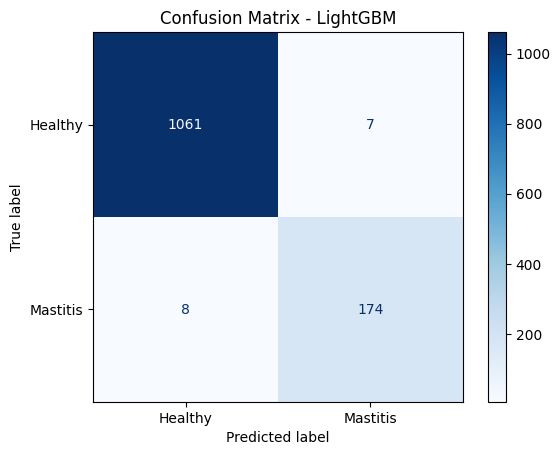

In [30]:
# CELL 12 — Comparison & confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Logistic Regression F1:", f1_score(y_test, y_pred_lr))
print("LightGBM F1:", f1_score(y_test, y_pred_lgbm))

# Confusion matrix for LightGBM
cm = confusion_matrix(y_test, y_pred_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy","Mastitis"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - LightGBM")
plt.show()


## 🧠 Step 8 – Model Explainability using SHAP

To make the LightGBM model’s decisions interpretable, **SHAP (SHapley Additive exPlanations)** is used.  
SHAP assigns an importance value to each feature for every prediction, helping explain why a sample is classified as mastitic or healthy.

Key aspects of SHAP analysis:
- **Global Importance:** Shows which features most influence model predictions overall.  
- **Local Importance:** Explains how specific feature values affect individual predictions.  
- **Scientific Relevance:** Confirms if the model’s logic aligns with biological understanding of mastitis.


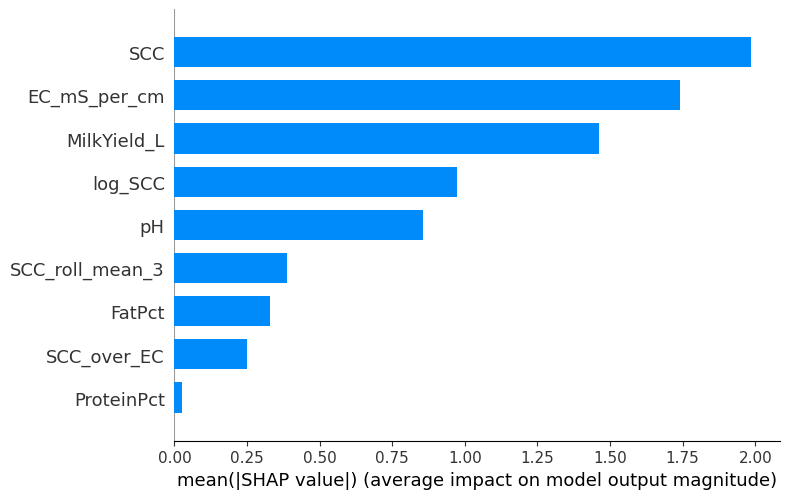

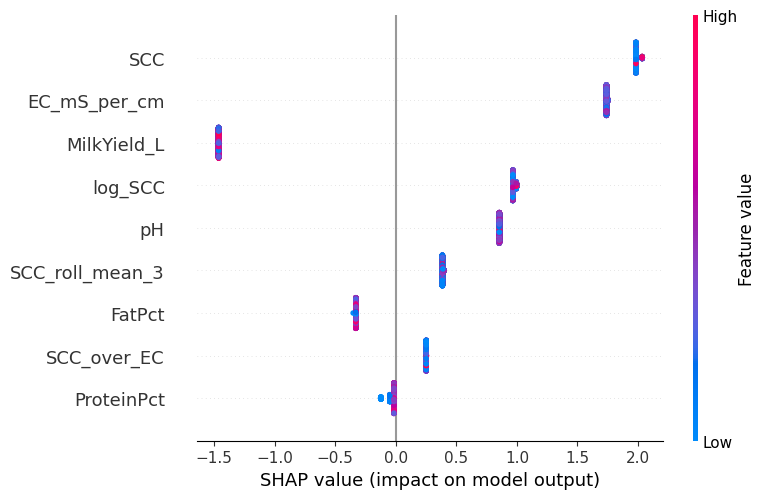

In [31]:
# CELL 13 — SHAP explainability
# Use TreeExplainer for LightGBM for speed
explainer = shap.TreeExplainer(lgbm, feature_perturbation="interventional")
# pass in the original (unscaled) test features so SHAP feature values map cleanly to names
X_test_for_shap = X_test.copy()
shap_values = explainer.shap_values(scaler.inverse_transform(X_test_scaled))  # inverse scaling for interpretability

# Summary bar plot (global importance)
shap.summary_plot(shap_values, X_test_for_shap, plot_type="bar")

# Summary dot plot (feature impact distribution)
shap.summary_plot(shap_values, X_test_for_shap)

# Example force plot for a single test sample (index 0)
idx = 0
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values[idx], X_test_for_shap.iloc[idx]))
plt.savefig("figure7_shap_bar.png", dpi=300, bbox_inches="tight")

### 🔬 Step 8.1 – SHAP Interpretation

The SHAP analysis clearly shows that **Somatic Cell Count (SCC)** and **Electrical Conductivity (EC_mS_per_cm)**  
are the dominant features driving the model’s predictions.  
Higher SCC and EC values increase the probability of mastitis, aligning with dairy science expectations.  

Other features such as **MilkYield_L**, **pH**, and **log_SCC** contribute moderately,  
indicating that production and acidity factors also influence the health condition.  

This explainability step verifies that the model’s reasoning is **biologically meaningful and transparent**,  
which is crucial for real-world veterinary adoption.

### 🧩 Step 8.2 – Detailed SHAP Feature Impact Analysis

The SHAP feature impact plot shows how high or low values of each feature influence mastitis prediction probability.

- **Red points (high values)** on the right increase the likelihood of mastitis.  
- **Blue points (low values)** on the left reduce it, corresponding to healthy samples.  

Key observations:
- **SCC** and **EC_mS_per_cm** have the largest positive impact on mastitis prediction.  
- **Lower Milk Yield** and **higher pH** values also contribute moderately.  
- **Nutritional indicators** (Fat% and Protein%) have minor yet meaningful influence.  

These findings confirm that the model’s learned relationships align closely with biological expectations  
and provide a transparent explanation of how it detects subclinical mastitis.


In [32]:
# CELL 14 — Save cleaned dataset and optionally persist the trained model to disk
# You can download these files from Colab file browser.

clean_csv_path = "mastitis_preprocessed_for_model.csv"
df[features + [label]].to_csv(clean_csv_path, index=False)
print("Saved preprocessed CSV:", clean_csv_path)

# Save model using joblib
import joblib
joblib.dump(lgbm, "lgbm_mastitis_model.joblib")
joblib.dump(scaler, "scaler.joblib")
print("Saved LightGBM model and scaler.")


Saved preprocessed CSV: mastitis_preprocessed_for_model.csv
Saved LightGBM model and scaler.


## ⚙️ Step 10 – Model Deployment and Real-time Prediction

To demonstrate practical deployment, the trained LightGBM model and feature scaler are saved and reloaded for inference.  
This step shows how the model can be used in a real-world dairy setting to predict the mastitis status of a new milk sample  
based on physicochemical measurements.

The input features for prediction include:
- **SCC (Somatic Cell Count)**  
- **pH**  
- **EC_mS_per_cm (Electrical Conductivity)**  
- **log_SCC**, **SCC_over_EC**, **SCC_roll_mean_3**  
- **MilkYield_L**, **FatPct**, and **ProteinPct**

The system outputs a clear label:  
✅ **Healthy** or ⚠️ **Mastitis**.


In [33]:
import joblib

lgbm = joblib.load("lgbm_mastitis_model.joblib")
scaler = joblib.load("scaler.joblib")

# Example: Predict on new milk sample
sample = [[250000, 6.8, 5.3, np.log1p(250000), 250000/5.3, 250000, 22.0, 3.7, 3.2]]
sample_scaled = scaler.transform(sample)
prediction = lgbm.predict(sample_scaled)
print("Prediction:", "Mastitis" if prediction[0]==1 else "Healthy")


Prediction: Healthy


In [35]:
import joblib

lgbm = joblib.load("lgbm_mastitis_model.joblib")
scaler = joblib.load("scaler.joblib")

# Example: Predict on new milk sample
sample = [[1200000, 7.1, 6.1, np.log1p(1200000), 1200000/6.1, 1200000, 18.0, 3.5, 3.1]]
sample_scaled = scaler.transform(sample)
prediction = lgbm.predict(sample_scaled)
print("Prediction:", "Mastitis" if prediction[0]==1 else "Healthy")

Prediction: Mastitis


In [68]:
# 🧩 CELL 15 — Duplicate and class distribution check
# 1️⃣  Verify no duplicate rows exist (which could leak to both train and test)
# 2️⃣  Inspect label balance (class distribution)

duplicates = df.duplicated().sum()
print(f"Duplicate rows in dataset: {duplicates}")

print("\nClass distribution (percentage):")
print(df["Label"].value_counts(normalize=True) * 100)


Duplicate rows in dataset: 0

Class distribution (percentage):
Label
0    85.4
1    14.6
Name: proportion, dtype: float64


In [69]:
# 🧩 CELL 16 — Verify train/test split isolation
# Ensures no identical samples appear in both sets.

import numpy as np
train_hash = pd.util.hash_pandas_object(X_train).values
test_hash = pd.util.hash_pandas_object(X_test).values
overlap = np.intersect1d(train_hash, test_hash)
print("Overlap between train and test samples:", len(overlap))

if len(overlap) == 0:
    print("✅ No data leakage via overlapping samples.")
else:
    print("⚠️ Potential overlap detected — recheck split logic.")


Overlap between train and test samples: 0
✅ No data leakage via overlapping samples.


In [70]:
# 🧩 CELL 17 — Correlation of each numeric feature with the label
# Strong correlation is okay, but perfect (1.0) correlation signals leakage.

corr = df.corr(numeric_only=True)["Label"].abs().sort_values(ascending=False)
print("Absolute correlation of each feature with target:\n")
print(corr)


Absolute correlation of each feature with target:

Label              1.000000
SCC                0.772456
SCC_over_EC        0.688189
EC_mS_per_cm       0.672674
pH                 0.527644
SCC_roll_mean_3    0.466959
log_SCC            0.316597
MilkYield_L        0.311895
ProteinPct         0.144535
FatPct             0.103815
Name: Label, dtype: float64


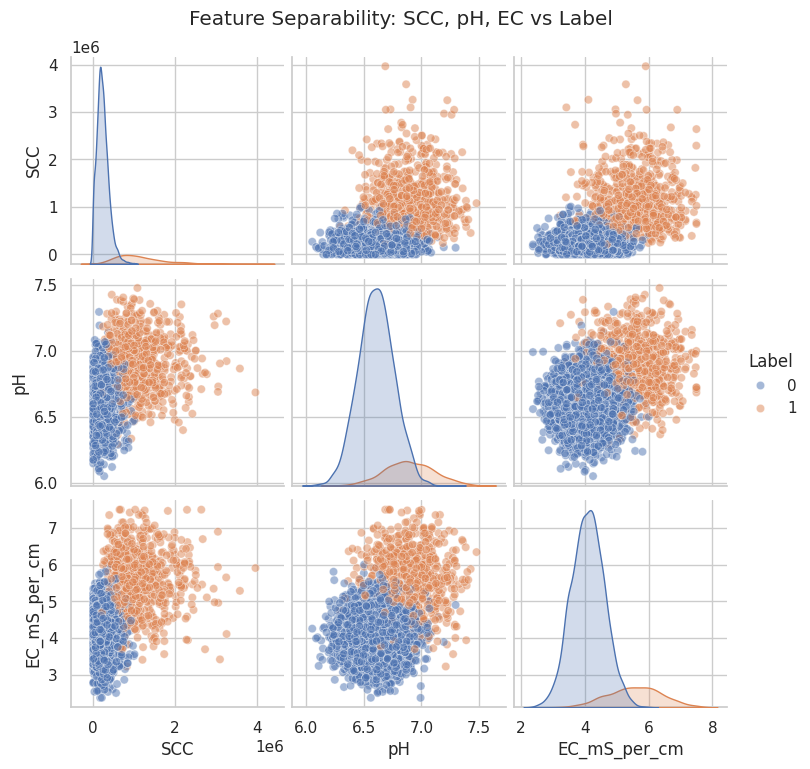

In [71]:
# 🧩 CELL 18 — Visualize feature separability between Healthy and Mastitis
# If clusters barely overlap, high accuracy is real, not leaked.

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.pairplot(df, vars=["SCC", "pH", "EC_mS_per_cm"], hue="Label", plot_kws={'alpha':0.5})
plt.suptitle("Feature Separability: SCC, pH, EC vs Label", y=1.02)
plt.show()
